# Roberta Fine Tuning

https://towardsdatascience.com/fine-tuning-bert-and-roberta-for-high-accuracy-text-classification-in-pytorch-c9e63cf64646

In [1]:
import pandas as pd
import torch
import torch.nn as nn 
from torchtext.data import Field,TabularDataset,BucketIterator,Iterator
from transformers import AutoConfig,AutoTokenizer,AutoModelForSequenceClassification,AdamW,get_linear_schedule_with_warmup,AutoModel

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
#  Check for CUDA
# Set random seed and set device to GPU.
torch.manual_seed(17)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on device: {device}, model: {torch.cuda.get_device_name(0)}')

Working on device: cuda, model: GeForce RTX 2060


In [3]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path='roberta-base')

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = 'roberta-base')

# model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased',config = model_config)

In [4]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 128
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [5]:
label = Field(sequential=False, use_vocab=False, batch_first=True)
text = Field(use_vocab=False, 
            tokenize=tokenizer.encode, 
            include_lengths=False, 
            batch_first=True,
            fix_length=MAX_SEQ_LEN, 
            pad_token=PAD_INDEX, 
            unk_token=UNK_INDEX)

In [6]:
fields = {'titletext' : ('titletext', text), 'label' : ('label', label)}

In [7]:
train_data,valid_data,test_data = TabularDataset.splits(path = '../Data/news/',train='news_train.csv',validation='news_validation.csv',test='news_test.csv',format = 'CSV',fields = fields,skip_header=False)

In [8]:
# Iterators

train_iter = BucketIterator(train_data,batch_size = BATCH_SIZE,sort_key = lambda x: len(x.titletext),
                            device = device,train=True,sort=True,sort_within_batch=False,shuffle=True)
valid_iter = BucketIterator(valid_data,batch_size = BATCH_SIZE,sort_key = lambda x: len(x.titletext),
                            device = device,train=True,sort=True,sort_within_batch=False,shuffle=True)
test_iter = Iterator(test_data,train=False,batch_size = BATCH_SIZE,device = device,sort=False, shuffle=False)

In [9]:
class NewsRoBerta(nn.Module):

    def __init__(self,n_classes):

        super(NewsRoBerta,self).__init__()
        self.roberta = AutoModel.from_pretrained("roberta-base")
        self.roberta_drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size,n_classes)

    def forward(self,input_ids,attention_mask):
        _,pooled_output  = self.roberta(input_ids = input_ids,attention_mask = attention_mask)
        output = self.roberta_drop(pooled_output)
        return self.out(output)

In [10]:
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [11]:
def pretrain(model,
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5,
             output_path='../model/NewsRoBerta/'):

    best_valid_loss = float('Inf')

    for param in model.roberta.parameters():
       param.requires_grad=False
    
    model.train()

    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  


    for epoch in tqdm(range(num_epochs)):
        for (source, target), _ in train_iter:
            mask = (source!=PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids =source,attention_mask = mask)

            loss = nn.CrossEntropyLoss()(y_pred, target)

            loss.backward()

            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            if global_step % valid_period == 0:
                model.eval()

                with torch.no_grad():
                    for (source, target), _ in train_iter:
                        mask = (source!=PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids =source,attention_mask = mask)

                        loss = nn.CrossEntropyLoss()(y_pred, target)

                        valid_loss+=loss.item()
                
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)

                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))

                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss

                train_loss = 0.0                
                valid_loss = 0.0


    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')
    save_checkpoint(output_path + '/' + 'pretrained_model.pt', model, best_valid_loss)
    print('Pretrained Model Saved to path: {file_path}/model.pt}')

In [12]:
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = '../model/NewsRoBerta'):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in tqdm(range(num_epochs)):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}] | Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/' + 'finetuned_model.pt', model, best_valid_loss)
                    save_metrics(output_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [13]:
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = NewsRoBerta(n_classes=2)
model = model.to(device)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)


In [15]:
pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

Epoch [1/6], global step [221/1326], Train Loss Loss: 0.6807, Val Loss: 1.7170
Epoch [2/6], global step [442/1326], Train Loss Loss: 0.6906, Val Loss: 1.6859
Epoch [3/6], global step [663/1326], Train Loss Loss: 0.6929, Val Loss: 1.6531
Epoch [4/6], global step [884/1326], Train Loss Loss: 0.6958, Val Loss: 1.6186
Epoch [5/6], global step [1105/1326], Train Loss Loss: 0.6965, Val Loss: 1.5978
Epoch [6/6], global step [1326/1326], Train Loss Loss: 0.6941, Val Loss: 1.5942

Pre-training done!
Pretrained Model Saved to path: {file_path}/model.pt}


In [16]:
import gc

del model
gc.collect()
torch.cuda.empty_cache()

In [17]:
model = NewsRoBerta(n_classes=2)
load_checkpoint('../model/NewsRoberta' + '/' + 'model.pt',model)
model = model.to(device)

In [18]:
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Epoch [1/6], global step [221/1326] | Train Loss: 0.7337, Valid Loss: 0.7104
Epoch [2/6], global step [442/1326] | Train Loss: 0.5255, Valid Loss: 0.1253
Epoch [3/6], global step [663/1326] | Train Loss: 0.0987, Valid Loss: 0.0847
Epoch [4/6], global step [884/1326] | Train Loss: 0.0600, Valid Loss: 0.0625
Epoch [5/6], global step [1105/1326] | Train Loss: 0.0370, Valid Loss: 0.0635
Epoch [6/6], global step [1326/1326] | Train Loss: 0.0336, Valid Loss: 0.0742

Training done!


In [19]:
del model
gc.collect()
torch.cuda.empty_cache()

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

def evaluate(model,test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():

        for index,((source, target), _) in tqdm(enumerate(test_loader),total=len(test_loader)): 
            mask = (source != PAD_INDEX).type(torch.uint8)
                
            output = model(source, attention_mask=mask)

            y_pred.extend(torch.argmax(output, axis=-1).tolist())
            y_true.extend(target.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4)) 

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")   

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])


Classification Report:
              precision    recall  f1-score   support

           1     0.9854    0.9728    0.9791       626
           0     0.9735    0.9858    0.9796       634

    accuracy                         0.9794      1260
   macro avg     0.9795    0.9793    0.9794      1260
weighted avg     0.9794    0.9794    0.9794      1260



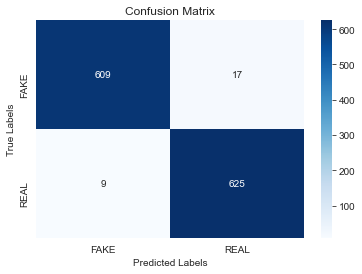

In [21]:
model = NewsRoBerta(n_classes=2)
model = model.to(device)
load_checkpoint('../model/NewsRoberta' + '/' + 'finetuned_model.pt', model)

evaluate(model,test_iter)